In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# ※ Quiz : 경주여행과 전주여행에 대해 최빈단어시각화와 유사도분석
- (1) naver open API를 활용하여 네이버지식인 "전주여행", "경주여행"를 각각 500건씩 검색 백업(naver.csv)
    * replace(), re.sum()이용
    * 백업 파일 결과 : query,no,title,link,description,total_text(title+' '+description)
- (2) 품사태깅 백업(naver_pos.csv)
    * query, no, token, pos
- (3) 명사만 추출 백업(naver_pos_nouns.csv)
    * query, token, pos
- (4) 빈도분석 백업(naver_pos_nouns_count.csv)
    * token, 경주빈도, 전주빈도, 빈도합
- (5) 빈도 시각화(워드클라우드, Text.plot)
    * 워드클라우드 이미지 저장
- (6) 단어간 유사도 분석(Word2Vec, 연관분석)

# 1. naver open API를 활용하여 검색어 500건 추출
- query,no,title,link,description,total_text(title+' '+description)

In [8]:
# (1)
import pandas as pd
import requests
import re

In [9]:
# .env 가져오기 (방법1) -추천
from dotenv import load_dotenv
import os
load_dotenv()

# print(os.getenv('CLIENT_ID'))
# print(os.getenv('CLIENT_SECRET'))

True

In [10]:
# env 가져오기 (방법2)
from decouple import config
# print(config('CLIENT_ID'))
# print(config('CLIENT_SECRET'))

In [11]:
#방법 1
import re
import requests
import pandas as pd
import json # response 텍스트를 json스타일의 딕셔너리로 
from html import unescape # description에 &lt; 등의 특수문자를 <(문자)>fh qusrud


client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
query = "경주 여행"
start=1
headers={
    'X-Naver-Client-Id':client_id,
    'X-Naver-Client-Secret':client_secret
}
# url = f"https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start}"
# response= requests.get(url, headers=headers)
url= 'https://openapi.naver.com/v1/search/kin'
params= {'query':query, 'display':100, 'start':start}
response= requests.get(url, params=params, headers=headers)
# print(response.text[:500])
# json.loads(response.text)['items']
items= response.json()['items']
print(len(items))


100


In [12]:
# title, link, description 추출(b태그삭제, 특수문자조정(&gt; -> > ), 정규표현식을 이용한 한글추출 )
item= items[97]
title= item.get('title').replace('<b>', ' ').replace('</b>', '')
link = item['link']
description= item.get('description').replace('<b>', ' ').replace('</b>', '')
# html특수문자처리
description= unescape(description)
# 정규표현식: 알파벳, 숫자, 한글만 남기고 나머지는 제거
description= re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
description= re.sub('\s+',' ',description)
print(title, link, description)

 경주 여행지 추천 https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90111&docId=261370795&qb=6rK97KO8IOyXrO2WiQ==&enc=utf8  2 부산을 벗어난 경주 여행지 알려주세요 3 당일치기로 경주 여행코스 밑에 자세하게 권역별로 여행코스를 소개했습니다 경주여행이 처음이라면 대릉원 첨성대 참고로 쭈니아빠 블로그를 방문하시면 경주여행 


In [13]:
def get_search_element_return(query, start):
    headers={
    'X-Naver-Client-Id':client_id,
    'X-Naver-Client-Secret':client_secret
    }
    # url = f"https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start}"
    # response= requests.get(url, headers=headers)
    url= 'https://openapi.naver.com/v1/search/kin'
    params= {'query':query, 'display':100, 'start':start}
    response= requests.get(url, params=params, headers=headers)
    # print(response.text[:500])
    # json.loads(response.text)['items']
    
    items= response.json()['items']
    print(len(items))
    result = []# 검색한 정보를 append할 리스트
    
    for i,item in enumerate(items):
        title= item.get('title').replace('<b>', ' ').replace('</b>', ' ')
        link= item.get('link')
        description= item.get('description').replace('<b>', ' ').replace('</b>', ' ')
        
        #특수문자 처리
        description= unescape(description)
        
        #영문자, 숫자, 한글을 제외한 문자 제거
        description= re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
        description= re.sub('\s+',' ',description)
        result.append({
            'query':query,
            'no':(start-1)*100 + i +1,
            'title':title,
            'link':link,
            'description':description,
            'total_text':title + ' ' + description
        })
    return result

In [14]:
get_search_element_return("전주 여행",2)

100


[{'query': '전주 여행',
  'no': 101,
  'title': 'KTX로 떠나는  전주 여행 , 주요 관광지 도보 이동... ',
  'link': 'https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90110&docId=489674913&qb=7KCE7KO8IOyXrO2WiQ==&enc=utf8',
  'description': ' 전주 여행 계획 중이시군요 전주역에서 한옥마을까지는 사실 도보로는 좀 멀어요 약 3km 정도 되고 40분 정도 걸립니다 그래서 대부분 택시나 버스를 이용하시는데 택시는 10분 정도면 도착하고 요금도 7 8천원 정도로 부담 없어요 ',
  'total_text': 'KTX로 떠나는  전주 여행 , 주요 관광지 도보 이동...   전주 여행 계획 중이시군요 전주역에서 한옥마을까지는 사실 도보로는 좀 멀어요 약 3km 정도 되고 40분 정도 걸립니다 그래서 대부분 택시나 버스를 이용하시는데 택시는 10분 정도면 도착하고 요금도 7 8천원 정도로 부담 없어요 '},
 {'query': '전주 여행',
  'no': 102,
  'title': '아이와  전주여행 ',
  'link': 'https://kin.naver.com/qna/detail.naver?d1id=9&dirId=901&docId=486608876&qb=7KCE7KO8IOyXrO2WiQ==&enc=utf8',
  'description': '7월 중순에 초3아이와 같이 당일치기로 전주여행 다녀올려는데 어딜가야할까요 전주는 처음이라 어디가야할지 식당은 어디가 맛있을지 모르겠어요 안녕하세요 7월 중순에 초3 아이와 전주 당일치기 여행이라면 아이도 즐겁고 부모님도 ',
  'total_text': '아이와  전주여행  7월 중순에 초3아이와 같이 당일치기로 전주여행 다녀올려는데 어딜가야할까요 전주는 처음이라 어디가야할지 식당은 어디가 맛있을지 모르겠어요 안녕하세요 7월 중순에 초3 아이와 전주 당일치기 여행이라면 아이도

In [15]:
import time
result_total= [] #모든 검색 결과
queries= ['전주 여행', '경주 여행']

max_start =5
for query in queries:
    for start in range(1, max_start+1):
        print(start, query, '읽는 중')
        result_total.extend(get_search_element_return(query,start))
        time.sleep(0.5)
df= pd.DataFrame(result_total)
df.head()
df.to_csv('data/naver.csv', index= False, encoding='cp949')

1 전주 여행 읽는 중
100
2 전주 여행 읽는 중
100
3 전주 여행 읽는 중
100
4 전주 여행 읽는 중
100
5 전주 여행 읽는 중
100
1 경주 여행 읽는 중
100
2 경주 여행 읽는 중
100
3 경주 여행 읽는 중
100
4 경주 여행 읽는 중
100
5 경주 여행 읽는 중
100


# 2. 품사태깅 백업
- query, no, token, pos

In [16]:
import pandas as pd
df= pd.read_csv('data/naver.csv',encoding='cp949')
df.head(100)

,query,no,title,link,description,total_text
0,전주 여행,1,"25년10월5,6,7일 전주여행",https://kin.naver.com/qna/detail.naver?d1id=9&...,전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가...,"25년10월5,6,7일 전주여행 전주여행 가볼만한 곳 추천부탁드립니다 25년 ..."
1,전주 여행,2,"KTX로 떠나는 전주 여행 , 주요 관광지 도보 이동...",https://kin.naver.com/qna/detail.naver?d1id=9&...,전주 여행 계획 중이시군요 전주역에서 한옥마을까지는 사실 도보로는 좀 멀어요 약 ...,"KTX로 떠나는 전주 여행 , 주요 관광지 도보 이동... 전주 여행 계획 중..."
2,전주 여행,3,아이와 전주여행,https://kin.naver.com/qna/detail.naver?d1id=9&...,7월 중순에 초3아이와 같이 당일치기로 전주여행 다녀올려는데 어딜가야할까요 전주는 ...,아이와 전주여행 7월 중순에 초3아이와 같이 당일치기로 전주여행 다녀올려는데 어...
3,전주 여행,4,전주 커플 여행 1박 2일 코스에 포함된 문화 체험 활동은...,https://kin.naver.com/qna/detail.naver?d1id=9&...,전주 여행 중 커플들이 함께 즐길 수 있는 문화 체험 활동에는 어떤 것들이 포함되...,전주 커플 여행 1박 2일 코스에 포함된 문화 체험 활동은... 전주 여행...
4,전주 여행,5,중2 여학생 친구와 전주여행,https://kin.naver.com/qna/detail.naver?d1id=9&...,안녕하세요 중 2 15살 여학생입니다 친한친구와 둘이서 전주 여행 을 가기로 했는데...,중2 여학생 친구와 전주여행 안녕하세요 중 2 15살 여학생입니다 친한친구와 둘...
...,...,...,...,...,...,...
95,전주 여행,96,전주여행 순서좀 알려주세요~,https://kin.naver.com/qna/detail.naver?d1id=12...,전주여행 을 하려고 하는데요 덕진공원 전주동물원 한옥마을 남부시장을 가려고 합니다...,전주여행 순서좀 알려주세요~ 전주여행 을 하려고 하는데요 덕진공원 전주동물원 ...
96,전주 여행,97,전주 여행 음식점,https://kin.naver.com/qna/detail.naver?d1id=12...,25일날 전주여행 을 가는데 전주동물원이랑 레일바이크 아중저수지 오목대주변에 맛집이...,전주 여행 음식점 25일날 전주여행 을 가는데 전주동물원이랑 레일바이크 아중저수...
97,전주 여행,98,전주 여행 가려 합니다~,https://kin.naver.com/qna/detail.naver?d1id=12...,금요일 저녁에서 토요일까지 1박 2일로 전주 여행 을 가려고 합니다 1 한옥마을에서...,전주 여행 가려 합니다~ 금요일 저녁에서 토요일까지 1박 2일로 전주 여행 을 ...
98,전주 여행,99,전주 1박2일 여행 코스,https://kin.naver.com/qna/detail.naver?d1id=9&...,질문하신 내용을 토대로 1박2일 일정으로 전주 여행 코스를 정리했습니다 참고해주세...,전주 1박2일 여행 코스 질문하신 내용을 토대로 1박2일 일정으로 전주 여행...


In [17]:
df_list= df[['query','no','total_text']].values.tolist()
df_list[::250]

[['전주 여행',
  1,
  '25년10월5,6,7일  전주여행   전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 '],
 ['전주 여행',
  251,
  '[추천해주세요]  전주  당일치기  여행   추천해주세요 전주 당일치기 여행 전주여행 전주맛집 국내여행 전주달봉이 달봉티비 전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행 제주도가볼만한곳 여행 전문 인플루언서 전주달봉이입니다 '],
 ['경주 여행',
  1,
  'APEC 기간  경주여행  APEC 기간 경주여행 어떻게 생각하시나요 APEC 기간에 경주여행 은 좋은 방법이에요 역사와 문화가 가득한 도시에서 특별한 경험을 할 수 있을 거에요 즐거운 여행 되세요 '],
 ['경주 여행',
  251,
  ' 경주 여행  코스 어디가★ 가족들이랑 경주여행 을 가려고 하는데 경주 여행 코스를 어떻게 해야할지 모르겟네요 경주 여행 코스 어디가 좋을까요 사실 중학교때 가보고 안가봤어요 경주 여행 코스 가장 핫플레이스만 가보고 싶어요 혹시 경주 여행 코스 다들 ']]

In [24]:
from mecab import MeCab
analyzer = MeCab()
stopwords = {'전주', '경주', '여행'}
select_pos = ['NNG', 'NNP'] # mecab의 명사 pos tag

postagged_list = [] # query, no, token, pos 딕셔너리 list
for i, row in enumerate(df_list):
    query = row[0]
    no    = row[1]
    text  = row[2]
    tagged_text = analyzer.pos(text)
#     if i%250==0:
#         print("{}의 {}번째 품사태깅결과 : {}개".format(query, no, len(tagged_text)))
    for token, pos in tagged_text:
        if token not in stopwords: # 불용어 제외. 한글자 이상만 append
            postagged_list.append({
                'query':query,
                'no':no,
                'token':token,
                'pos':pos
            })
df_postagged = pd.DataFrame(postagged_list)
df_postagged.to_csv('data/naver_pos.csv', index=False, encoding='cp949')

# 3. 명사만 추출

In [26]:
import pandas as pd
df_postagged = pd.read_csv('data/naver_pos.csv', encoding='cp949')
df_postagged.head()

,query,no,token,pos
0,전주 여행,1,25,SN
1,전주 여행,1,년,NNBC
2,전주 여행,1,10,SN
3,전주 여행,1,월,NNBC
4,전주 여행,1,5,SN


In [30]:
select_pos = ['NNG', 'NNP']
df_nouns= df_postagged[df_postagged['pos'].isin(select_pos)]
df_nouns.to_csv('data/naver_pos_nouns.csv', index=False, encoding='cp949')

# 4.빈도분석
- token 경주빈도 전주빈도 빈도합

In [31]:
df_nouns= pd.read_csv('data/naver_pos_nouns.csv', encoding='cp949')
df_nouns.head()

,query,no,token,pos
0,전주 여행,1,곳,NNG
1,전주 여행,1,추천,NNG
2,전주 여행,1,부탁,NNG
3,전주 여행,1,아이,NNG
4,전주 여행,1,시점,NNG


In [32]:
df_nouns.groupby(['query','token'], as_index=False)['pos'].count()

query  token
경주 여행  가격        5
       가능       30
       가보세요     10
       가본적       5
       가시        5
                ..
전주 여행  효율        5
       후         5
       휴가        5
       휴무        5
       흐노        5
Name: pos, Length: 1001, dtype: int64

In [35]:
df_token_grp= df_nouns.groupby('query')['token'].value_counts()
df_token_grp= df_token_grp.reset_index(name='token_count')

In [36]:
df_token_grp.head()

,query,token,token_count
0,경주 여행,코스,447
1,경주 여행,추천,424
2,경주 여행,계획,151
3,경주 여행,곳,134
4,경주 여행,맛집,133


In [42]:
df_gj = df_token_grp.loc[df_token_grp['query']=='경주 여행', ['token','token_count']]
df_jj = df_token_grp.loc[df_token_grp['query']=='전주 여행', ['token','token_count']]
df_gj.shape , df_jj.shape

((535, 2), (466, 2))

In [43]:
df_gj.head()

,token,token_count
0,코스,447
1,추천,424
2,계획,151
3,곳,134
4,맛집,133


In [44]:
df_jj.head()

,token,token_count
535,코스,459
536,곳,433
537,봉,330
538,맛집,322
539,여수,315


In [48]:
#df_gj(경주 명사 출현횟수), df_jj(전주 명사 출현 횟수)병합
import numpy as np
df_mrg= pd.merge(df_gj, df_jj, on='token', how='outer')
df_mrg.columns= ['token','경주빈도','전주빈도']
df_mrg.fillna(0, inplace=True)
df_mrg['경주빈도'] =df_mrg['경주빈도'].astype('int')
df_mrg['전주빈도'] = df_mrg['전주빈도'].astype(np.int32)
df_mrg.head()

,token,경주빈도,전주빈도
0,코스,447,459
1,추천,424,289
2,계획,151,64
3,곳,134,433
4,맛집,133,322


In [49]:
df_mrg['빈도합'] = df_mrg['경주빈도']+df_mrg['전주빈도']
df_mrg['경주비율'] = df_mrg['경주빈도']/df_mrg['빈도합']
df_mrg['전주비율'] = df_mrg['전주빈도']/df_mrg['빈도합']
df_mrg['경주비율'] = df_mrg['경주비율'].apply(lambda x : "{:.2%}".format(x))
df_mrg['전주비율'] = df_mrg['전주비율'].apply(lambda x : "{:.2%}".format(x))
df_mrg.to_csv('data/naver_pos_nouns_count.csv', index=False, encoding='cp949')

# 5. 
- 전주여행 워드클라우드/ 경주여행 워드 클라우드

In [50]:
df_nouns= pd.read_csv('data/naver_pos_nouns.csv', encoding='cp949')
df_nouns.loc[::5000]

,query,no,token,pos
0,전주 여행,1,곳,NNG
5000,전주 여행,273,현대,NNG
10000,경주 여행,54,지,NNG
15000,경주 여행,377,추천,NNG


In [55]:
df_gj_noun_list= df_nouns.loc[df_nouns['query']=='경주 여행', 'token'].to_list()
df_jj_noun_list= df_nouns.loc[df_nouns['query']=='전주 여행', 'token'].to_list()
gj_text= ' '.join(df_gj_noun_list)
jj_text= ' '.join(df_jj_noun_list)

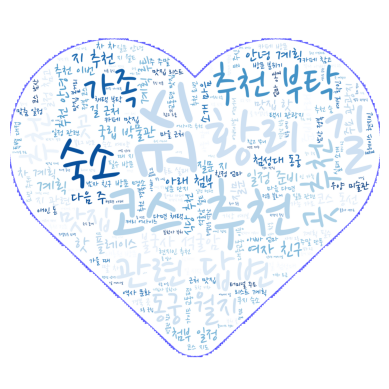

In [65]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
img= Image.open('data/heart.jpg')
mask= np.array(img)

wordcloud= WordCloud(
    font_path='data/NanumPenScript-Regular.ttf',
    background_color='white',
    colormap='Blues',
    collocations=True, #특정단어가 자주 같이 나오면 같이 뿌려 ex황리길
    max_words=200,
    scale=2, # 이미지 크기의 비율(파일 저장시 차이난다)
    mask=mask,
    contour_color='blue',
    contour_width=1
    
).generate(gj_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [66]:
# 생성된 wordcloud저장
wordcloud.to_file('data/naver_경주.jpg')

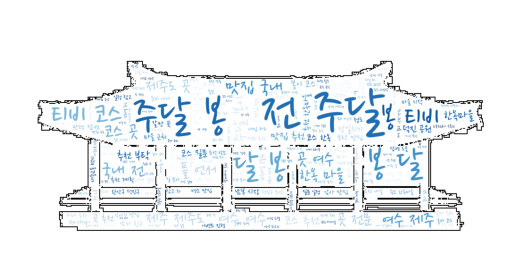

In [73]:
img= Image.open('data/korea-house-black-fill.png')
mask= np.array(img)

wordcloud= WordCloud(
    font_path='data/NanumPenScript-Regular.ttf',
    background_color='white',
    colormap='Blues',
    collocations=True, #특정단어가 자주 같이 나오면 같이 뿌려 ex황리길
    max_words=200,
    scale=2, # 이미지 크기의 비율(파일 저장시 차이난다)
    mask=mask,
    contour_color='black',
    contour_width=1
    
).generate(jj_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [68]:
# 생성된 wordcloud저장
wordcloud.to_file('data/naver_전주.jpg')

# 빈도수 시각화

In [74]:
df_gj_noun_list= df_nouns.loc[df_nouns['query']=='경주 여행', 'token'].to_list()
df_jj_noun_list= df_nouns.loc[df_nouns['query']=='전주 여행', 'token'].to_list()

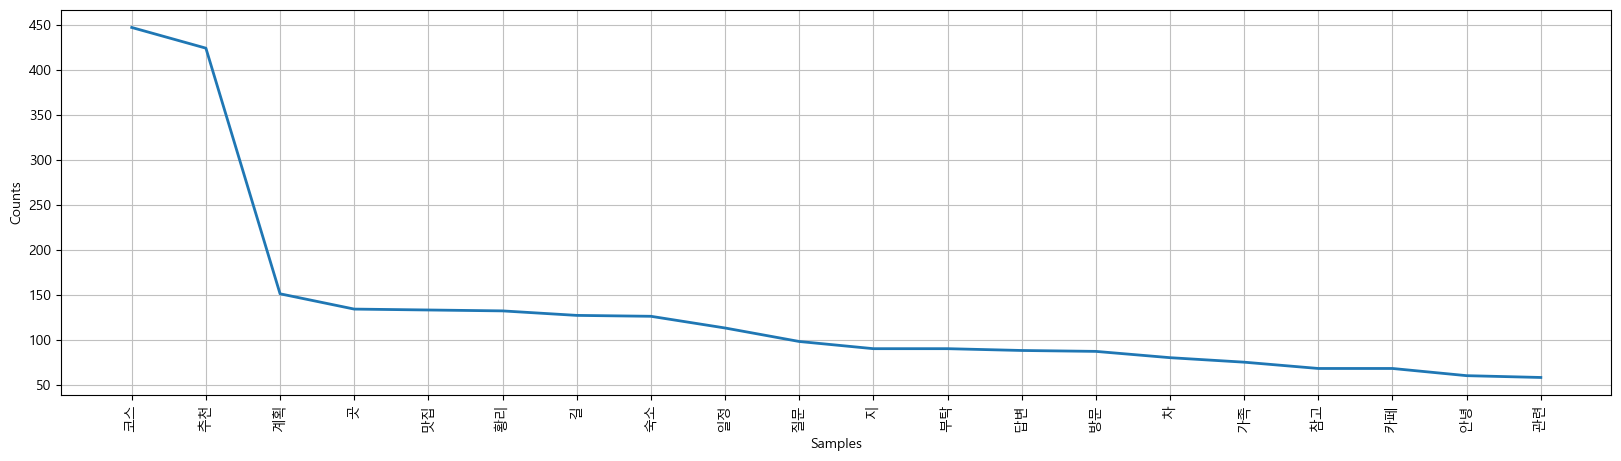

In [77]:
import nltk
data_text= nltk.Text(df_gj_noun_list)
plt.figure(figsize=(20,5))
plt.rc('font', family='Malgun Gothic')
data_text.plot(20)
plt.show()

('코스', '추천', '계획', '곳', '맛집', '황리', '길', '숙소', '일정', '질문', '지', '부탁', '답변', '방문', '차', '가족', '참고', '카페', '안녕', '관련')
(447, 424, 151, 134, 133, 132, 127, 126, 113, 98, 90, 90, 88, 87, 80, 75, 68, 68, 60, 58)


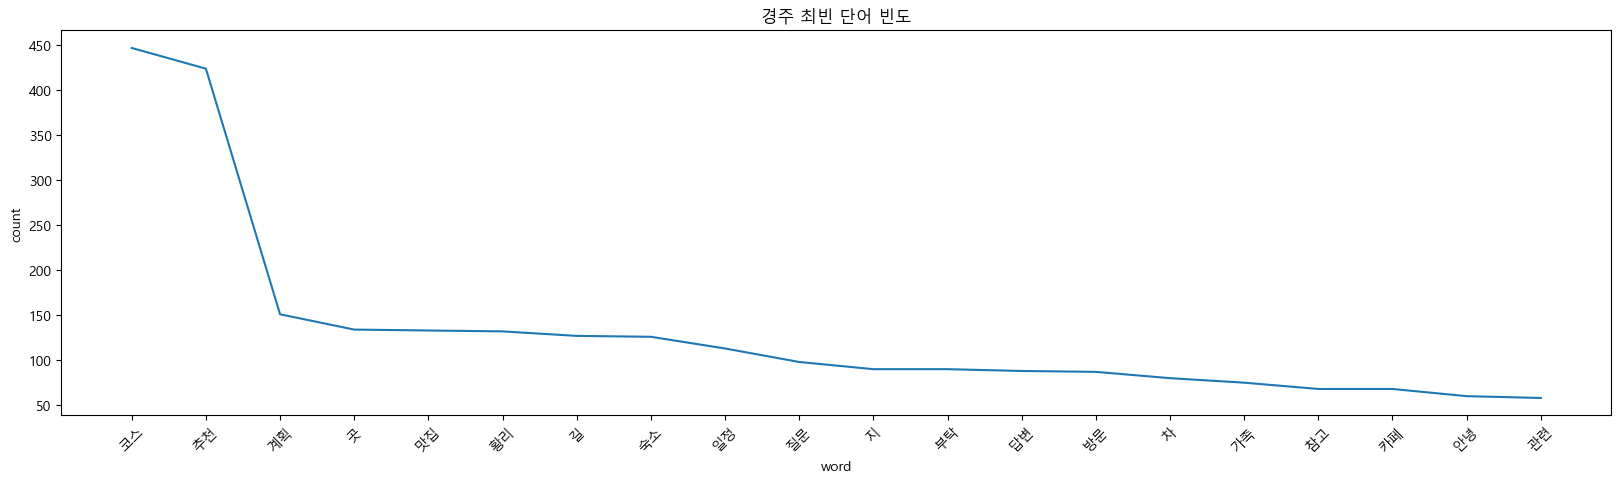

In [80]:
word, counts = zip(* data_text.vocab().most_common(20))
print(word)
print(counts)
plt.figure(figsize=(20,5))
plt.plot(word, counts)
plt.xticks(rotation=45)
plt.xlabel('word')
plt.ylabel('count')
plt.title('경주 최빈 단어 빈도')
plt.show()

# 6. 유사도 분석
## word2Vec

In [82]:
df= pd.read_csv('data/naver.csv',encoding='cp949')
df.sample()

,query,no,title,link,description,total_text
387,전주 여행,388,(급합니다ㅠㅠ) 전주 여행 코스,https://kin.naver.com/qna/detail.naver?d1id=12...,전주여행 코스 추천드립니다 안녕하세요 여행전문블로거 쭈니아빠입니다 방학을 맞아서 ...,(급합니다ㅠㅠ) 전주 여행 코스 전주여행 코스 추천드립니다 안녕하세요 여행전문블...


In [83]:
total_text_list= df['total_text'].to_list()
total_text_list[:2]

['25년10월5,6,7일  전주여행   전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 ',
 'KTX로 떠나는  전주 여행 , 주요 관광지 도보 이동...   전주 여행 계획 중이시군요 전주역에서 한옥마을까지는 사실 도보로는 좀 멀어요 약 3km 정도 되고 40분 정도 걸립니다 그래서 대부분 택시나 버스를 이용하시는데 택시는 10분 정도면 도착하고 요금도 7 8천원 정도로 부담 없어요 ']

In [89]:
from mecab import MeCab
select_pos= ['NNP','NNG']
불용어= {'여행'}
analyzer= MeCab()
total_noun_list=[]
for total_text in total_text_list:
    noun_list= [token for token,tag in analyzer.pos(total_text)
               if tag in select_pos and
               token not in 불용어 and
               len(token)>1]
    total_noun_list.append(noun_list)
print(total_noun_list[:2])

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['전주', '주요', '관광지', '도보', '이동', '전주', '계획', '주역', '한옥마을', '도보', '정도', '정도', '대부분', '택시', '버스', '이용', '택시', '정도', '도착', '요금', '정도', '부담']]


In [90]:
from gensim.models import Word2Vec
model= Word2Vec(total_noun_list, window=10, min_count=2, workers=-1,
               sg=1) #소량 데이터


In [91]:
model.wv.most_similar('전주')

[('식사', 0.3595535457134247),
 ('동선', 0.2897421419620514),
 ('리스트', 0.275379478931427),
 ('덕진구', 0.2731468081474304),
 ('현재', 0.2580290138721466),
 ('가격', 0.2295033037662506),
 ('반려', 0.22023281455039978),
 ('답변', 0.21883943676948547),
 ('한옥마을', 0.21617142856121063),
 ('허락', 0.2135322391986847)]

In [92]:
model.wv.most_similar('경주')

[('호수', 0.3641005754470825),
 ('여름', 0.21867415308952332),
 ('배차', 0.21632219851016998),
 ('경기전', 0.2159893959760666),
 ('인근', 0.21469099819660187),
 ('황동', 0.2134207934141159),
 ('다랭이', 0.20914912223815918),
 ('봉길', 0.20906010270118713),
 ('남편', 0.2070489227771759),
 ('체계', 0.20607852935791016)]

# 연관분석

In [94]:
print(total_noun_list[:2])

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['전주', '주요', '관광지', '도보', '이동', '전주', '계획', '주역', '한옥마을', '도보', '정도', '정도', '대부분', '택시', '버스', '이용', '택시', '정도', '도착', '요금', '정도', '부담']]


In [97]:
%%time
from apyori import apriori
rules= apriori(total_noun_list, min_support=0.15, min_confidence=0.3, min_lift=0.01)
rules= list(rules)
len(rules)

CPU times: total: 31.2 ms
Wall time: 39.6 ms


132

In [100]:
import pandas as pd
rules_df = pd.DataFrame(None, columns=['lhs', 'rhs', '지지도','신뢰도', '향상도'])
idx = 0
for row in rules:
    support = row[1]
    ordered_st = row[2]
    for item in ordered_st:
        #print(item)
        lhs = item[0]
        lhs = ','.join([x for x in lhs])
        rhs = item[1]
        rhs = ','.join([x for x in rhs])
        confidence = item[2]
        lift = item[3]
        rules_df.loc[idx] = [lhs, rhs, support, confidence, lift]
        idx += 1
#         print("{:10}=>{:16}\t{}\t{}\t{:.2f}".format(lhs, rhs, support, 
#                                                 round(confidence, 2), 
#                                                 lift))
rules_df.sort_values(by=['신뢰도', '향상도'], ascending=False)
rules_df.head(20)

,lhs,rhs,지지도,신뢰도,향상도
0,,경주,0.500,0.500000,1.000000
1,,맛집,0.326,0.326000,1.000000
2,,전주,0.500,0.500000,1.000000
3,,추천,0.462,0.462000,1.000000
4,,코스,0.512,0.512000,1.000000
5,경주,추천,0.254,0.508000,1.099567
6,추천,경주,0.254,0.549784,1.099567
7,경주,코스,0.217,0.434000,0.847656
8,코스,경주,0.217,0.423828,0.847656
9,국내,맛집,0.160,0.969697,2.974531
